In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import librosa
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from algorithms import label_encode_columns, svm_model, accuracy_calculator, random_forest_model, array_column_spread, one_hot_encode_columns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("dsl_data/development.csv")
df_eval = pd.read_csv("dsl_data/evaluation.csv")

In [3]:
df['intent'] = df['action']+df['object']

In [4]:
# y encoded done
dict = {}

for i, el in enumerate(df['intent'].unique()):
    dict[el] = i

df['intent'] = df['intent'].apply(lambda x: dict[x])

In [5]:
columns = ["Self-reported fluency level ","First Language spoken", "Current language used for work/school", "gender"]

for column in columns:
    encoder = OneHotEncoder()
    encoded_data = encoder.fit_transform(df[[column]])
    feature_names = encoder.get_feature_names_out([column])
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=feature_names)
    df.drop(column, axis=1, inplace=True)
    df = pd.concat([df, encoded_df], axis=1)

In [6]:
le = LabelEncoder()
label = le.fit_transform(df['ageRange'])
df.drop('ageRange', axis=1, inplace=True)
df['ageRange'] = label

In [7]:
df.columns

Index(['Id', 'path', 'speakerId', 'action', 'object', 'intent',
       'Self-reported fluency level _advanced',
       'Self-reported fluency level _basic',
       'Self-reported fluency level _intermediate',
       'Self-reported fluency level _native',
       'First Language spoken_English (Canada)',
       'First Language spoken_English (United States)',
       'First Language spoken_French (Canada)',
       'First Language spoken_Spanish (Venezuela)',
       'First Language spoken_Telugu',
       'Current language used for work/school_English (Australia)',
       'Current language used for work/school_English (Canada)',
       'Current language used for work/school_English (United States)',
       'Current language used for work/school_Spanish (Venezuela)',
       'gender_female', 'gender_male', 'ageRange'],
      dtype='object')

In [8]:
def audio_feature_extraction(df):
        data_array= []
        rate_array = []
        for audio in df['path']:
                data, rate = librosa.load(audio)
                data_array.append(data)
                rate_array.append(rate)

        df['data'] = data_array
        df['rate'] = rate_array
audio_feature_extraction(df)

In [9]:
from scipy.stats import skew, kurtosis

def time_domain(df, column):
    df[f'{column}_mean'] = df[column].apply(lambda x: np.mean(x,axis=1))
    df[f'{column}_min'] = df[column].apply(lambda x: np.min(x,axis=1))
    df[f'{column}_max'] = df[column].apply(lambda x: np.max(x,axis=1))
    df[f'{column}_skew'] = df[column].apply(lambda x: skew(x,axis=1))
    df[f'{column}_kurtosis'] = df[column].apply(lambda x: kurtosis(x,axis=1))
    df[f'{column}_std'] = df[column].apply(lambda x: np.std(x,axis=1))

In [10]:
def chroma_feature(df):
    chroma_array = []
    for data, rate in zip(df['data'], df['rate']):
        chroma = librosa.feature.chroma_stft(y=data, sr=rate, n_chroma=7)
        chroma_array.append(chroma)
    df['chroma'] = chroma_array

chroma_feature(df)

In [11]:
time_domain(df,'chroma')

In [12]:
arr = ['chroma_mean','chroma_min','chroma_max','chroma_std','chroma_kurtosis','chroma_skew']
for i in arr:
    array_column_spread(df,i)

In [ ]:
def tonnetz_feature(df):
    tonnetz_array = []
    for data, rate in zip(df['data'], df['rate']):
        tonnetz = librosa.feature.tonnetz(y=data, sr=rate)
        tonnetz_array.append(tonnetz)
    df['tonnetz'] = tonnetz_array
tonnetz_feature(df)

In [14]:
time_domain(df,'tonnetz')
arr = ['tonnetz_mean','tonnetz_min','tonnetz_max','tonnetz_std','tonnetz_kurtosis','tonnetz_skew']
for i in arr:
    array_column_spread(df,i)

In [15]:
# down to 4 features
def spectral_contrast(df):
    spectral_contrast_array = []
    for data, rate in zip(df['data'], df['rate']):
        spectral_contrast = librosa.feature.spectral_contrast(y=data, sr=rate)
        spectral_contrast_array.append(spectral_contrast)
    df['spectral_contrast'] = spectral_contrast_array    
spectral_contrast(df)

In [ ]:
time_domain(df,'spectral_contrast')
arr = ['spectral_contrast_mean','spectral_contrast_min','spectral_contrast_max','spectral_contrast_std','spectral_contrast_kurtosis','spectral_contrast_skew']
for i in arr:
    array_column_spread(df,i)

In [ ]:
def rmse_feature(df):
    # create an empty list to store the RMSE values
    rmse_list = []

    # iterate through the audio files in the dataset
    for data, rate in zip(df['data'], df['rate']):
        # calculate the root mean square energy
        rmse = librosa.feature.rms(y=data)
        # append the rmse mean to the rmse_list
        rmse_list.append(rmse[0])

    # add the rmse_list as a new column to the dataframe
    df['rmse'] = rmse_list

rmse_feature(df)

In [ ]:
def time_domain2(df, column):
    df[f'{column}_mean'] = df[column].apply(lambda x: np.mean(x))
    df[f'{column}_min'] = df[column].apply(lambda x: np.min(x))
    df[f'{column}_max'] = df[column].apply(lambda x: np.max(x))
    df[f'{column}_skew'] = df[column].apply(lambda x: skew(x))
    df[f'{column}_kurtosis'] = df[column].apply(lambda x: kurtosis(x))
    df[f'{column}_std'] = df[column].apply(lambda x: np.std(x))
time_domain2(df,'rmse')

In [ ]:
def spectral_flatness(df):
    # create an empty list to store the SF values
    sf_list = []

    # iterate through the audio files in the dataset
    for data, rate in zip(df['data'], df['rate']):
        # calculate the spectral flatness
        sf = librosa.feature.spectral_flatness(y=data)
        # append the SF mean to the sf_list
        sf_list.append(sf[0])

    # add the sf_list as a new column to the dataframe
    df['sf'] = sf_list
spectral_flatness(df)

In [ ]:
time_domain2(df,'sf')

In [ ]:
def sro_feature(df):
    # Create an empty list to store the spectral roll-off values
    spectral_rolloff_array = []

    for data, rate in zip(df['data'], df['rate']):
        spectral_rolloff = librosa.feature.spectral_rolloff(y=data, sr=rate)
        spectral_rolloff_array.append(spectral_rolloff[0])

    # Add the spectral roll-off values to the dataframe as a new column
    df['spectral_rolloff'] = spectral_rolloff_array
sro_feature(df)

In [ ]:
time_domain2(df,'spectral_rolloff')

In [23]:
def zcr_feature(df):
    # Create arrays to store the zero-crossing rate values
    zero_crossing_rate_array = []

    for data in df['data']:
        
        # Compute the zero-crossing rate for the current audio file
        zero_crossing_rate = sum(librosa.zero_crossings(data))
        # Append the zero-crossing rate to the zero_crossing_rate_array
        zero_crossing_rate_array.append(zero_crossing_rate)

    # Add the zero-crossing rate arrays as new columns in the dataframe
    df['zero_crossing_rate'] = zero_crossing_rate_array
zcr_feature(df)

/var/folders/sj/p6ljt_pn2qv80z471vxgw4w40000gn/T/ipykernel_51220/3470447777.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['zero_crossing_rate'] = zero_crossing_rate_array


In [24]:
def mfcc_feature(df):
    # Create arrays to store the mfcc rate values
    mfcc_array = []

    for data, rate in zip(df['data'], df['rate']):
        
        # Compute the mfccs for the current audio file
        mfcc = librosa.feature.mfcc(y=data, sr=rate, n_mfcc=30)
        mfcc_array.append(mfcc)

    # Add the mfcc as a new column in the dataframe
    df['mfcc'] = mfcc_array
mfcc_feature(df)

/var/folders/sj/p6ljt_pn2qv80z471vxgw4w40000gn/T/ipykernel_51220/136636556.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['mfcc'] = mfcc_array


In [ ]:
time_domain(df,'mfcc')
arr = ['mfcc_mean','mfcc_min','mfcc_max','mfcc_std','mfcc_kurtosis','mfcc_skew']
for i in arr:
    array_column_spread(df,i)

In [26]:
df2 = df.copy()

# Iterate over each column in the DataFrame
for col in df2.columns:
    # Check if the column contains 1D or 2D arrays
    if isinstance(df2[col].values[0], (list, np.ndarray)) and len(df2[col].values[0]) > 1:
        # Drop the column if it contains 1D or 2D arrays
        df2.drop(col, axis=1, inplace=True)

In [27]:
arr1 = ['Id', 'path', 'speakerId', 'action', 'object', 'intent',
       'Self-reported fluency level _advanced',
       'Self-reported fluency level _basic',
       'Self-reported fluency level _intermediate',
       'Self-reported fluency level _native',
       'First Language spoken_English (Canada)',
       'First Language spoken_English (United States)',
       'First Language spoken_French (Canada)',
       'First Language spoken_Spanish (Venezuela)',
       'First Language spoken_Telugu',
       'Current language used for work/school_English (Australia)',
       'Current language used for work/school_English (Canada)',
       'Current language used for work/school_English (United States)',
       'Current language used for work/school_Spanish (Venezuela)',
       'gender_female', 'gender_male', 'ageRange', 'data', 'rate',]
# arr2 = df2.columns.to_list()
# arr3 = [x for x in arr2 if x not in arr1]

In [37]:
X = df2.copy()

In [38]:
X.drop(columns=['Id', 'path', 'speakerId', 'action', 'object', 'intent'], inplace=True)

In [39]:
len(X.columns)

336

In [46]:
import matplotlib.pyplot as plt

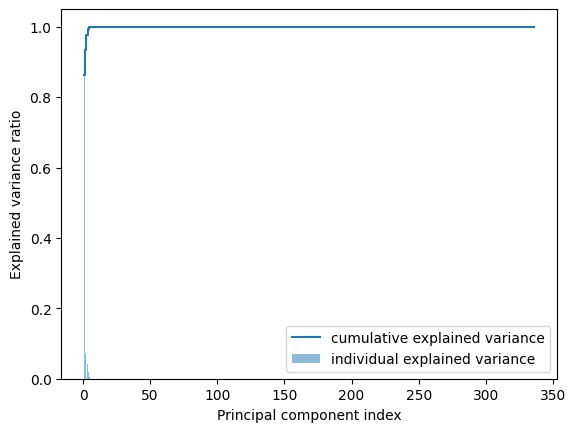

In [47]:
from sklearn.decomposition import PCA
import pandas as pd

# Assuming your dataframe is named 'df'

# Create an instance of PCA
pca = PCA()

# Fit PCA on the data
pca.fit(X)

# Get the explained variance ratio of each principal component
var_ratio = pca.explained_variance_ratio_

# Get the cumulative explained variance ratio
cum_var_ratio = np.cumsum(var_ratio)

# Plot the explained variance ratio
plt.bar(range(1, len(var_ratio)+1), var_ratio, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, len(cum_var_ratio)+1), cum_var_ratio, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()


# Create an instance of PCA, specifying the number of components to keep
pca = PCA(n_components=75)

# Fit PCA on the data
df_pca = pca.fit_transform(X)


In [50]:
df_pca

(9854, 75)

In [54]:
y = df['intent'].values

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df_pca, y, test_size=0.2, random_state=42)

In [57]:
from sklearn.svm import SVC


def svm_model2(X_train, y_train, X_test):
    clf = SVC()
    # train the model on the training data
    clf.fit(X_train, y_train)
    # predict the target values for the test data
    # returning the y_predict
    return clf.predict(X_test)
y_pred = svm_model2(X_train, y_train, X_test)
svm_accuracy = accuracy_calculator(y_test, y_pred)

In [58]:
svm_accuracy

0.2643328259766616

In [60]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)

# shuffle the data before performing k-fold cross validation
X_shuffled, y_shuffled = shuffle(X, y)

# perform k-fold cross validation with 5 folds
scores = cross_val_score(clf, X_shuffled, y_shuffled, cv=5)

# calculate the mean accuracy of the model across all folds
accuracy = np.mean(scores)
print("Accuracy:", accuracy)


Accuracy: 0.4461122829247438


In [ ]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

# Initialize the feature matrix and target variable

# Initialize the SVM model
svm = SVC(kernel="linear")

# Initialize RFE 
rfe = RFE(svm)

# Define the grid of values for the number of features to select and the accuracy required
param_grid = {'n_features_to_select':[60,70,80], 
              'estimator__C':[0.1, 1, 10], 
              'estimator__kernel':['linear', 'rbf', 'poly'], 
              'estimator__gamma': [0.1, 1, 10]}

# Define the scoring function
acc_scorer = make_scorer(accuracy_score)

# Initialize GridSearchCV
grid_search = GridSearchCV(rfe, param_grid, scoring=acc_scorer)

# Fit the grid_search to the data
grid_search.fit(X, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
support = grid_search.best_estimator_.support_

# Get the feature names
feature_names = X.columns

# Get the best features
best_features = feature_names[support]

# Print the best parameters, best score, and best features
print("Best parameters: ", best_params)
print("Best score: ", best_score)
print("Best features: ", best_features)